In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
from pytorch_models import *
import librosa
import librosa.display
import pytorch_models as pm
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram
#takes a billion years so commented
audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="stacks"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["stacks","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["stacks","guitar","piano"])]



In [2]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)

#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


label
clap         471
hat         1748
kick        1242
rim          236
snare       1573
stacks      3632
tom          349
tom_high     179
Name: path, dtype: int64


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


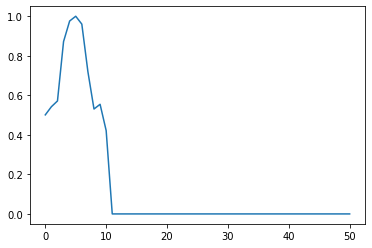

./dk_data/piano/146_0.wav


In [3]:
#get env feats
PATH_AUDIO=getRandAud()
def envTrans(wf,num_mels=50):
    melEnv=torchaudio.transforms.MelScale(n_mels=2*num_mels, sample_rate=SR, f_min=0.0, f_max=None, n_stft=None)
    wf=wf[:,0:15000]
    num_bins=wf[0].shape[0]//10

    # spec(wf, pad, window, n_fft, hop_length, win_length, power)
    win_length=num_bins
    window=torch.tensor([1]*win_length)
    s=spec(wf, 0, window, num_bins, win_length, win_length,2,normalized=False)
    s=melEnv(s)

    env=s.sum(axis=0).sum(axis=0)
    env=env/env.abs().max()
    env[torch.isnan(env)]=0

    num_padding=torch.max(torch.tensor([num_mels+1-env.shape[0],0]))
    env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
    return env_vec

og_w, sample_rate = torchaudio.load(PATH_AUDIO)  # load tensor from file
wf= ta.transforms.Resample(sample_rate,SR).forward(og_w)

env_feats=envTrans(wf)
plt.plot(env_feats)
plt.show()
print(PATH_AUDIO)
Audio(wf,rate=SR, autoplay=True)

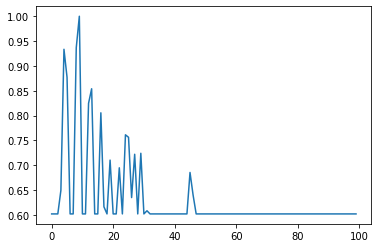

torch.Size([100])
./dk_data/guitar/44_0.wav


In [4]:
#get freq feats
PATH_AUDIO=getRandAud()
num_mels=100
def freqTrans(wf,num_mels=num_mels):
    ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
    mel=torchaudio.transforms.MelScale(n_mels=num_mels, sample_rate=SR, f_min=0.0, f_max=None, n_stft=None)
    PATH_AUDIO=getRandAud()

#     wf=wf[:,0:2000]
    num_bins=wf[0].shape[0//2]
    win_length=num_bins
    window=torch.tensor([1]*win_length)
    s=spec(wf, 100, window, num_bins, win_length, win_length,2,normalized=False)
    s=mel(s)
    s=ampT(s)
    freq=s.sum(axis=0).sum(axis=1)
    freq=freq/freq.abs().max()
    freq[torch.isnan(freq)]=0
    return freq.detach()

og_w, sample_rate = torchaudio.load(PATH_AUDIO)  # load tensor from file
wf= ta.transforms.Resample(sample_rate,SR).forward(og_w)

freq_feats=freqTrans(wf,num_mels=num_mels)

plt.plot(freq_feats)
plt.show()
print(freq_feats.shape)
print(PATH_AUDIO)
Audio(wf[0:15000],rate=SR, autoplay=True)


In [6]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
ds[np.random.randint(len(ds))]

all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)


('hat', 1) tensor(1) 44100


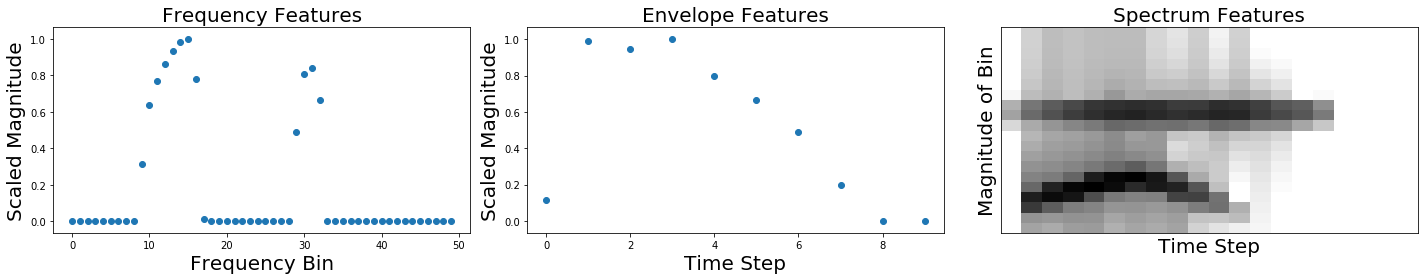

In [605]:

#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}
class specTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=15000.0, n_stft=None)
        self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//19
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        s=self.ampP(s)
        s=s/s.abs().max()
        freq=self.norm(s)
        return {"feats":freq.detach(),"label":label}
class envTrans(object):

    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]

        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
# sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=1, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(20)]
for i, tsfrm in enumerate(tfList):

    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
#     ax.set_title(type(tsfrm).__name__)
    ft=transformed_sample["feats"]
    if i==0:
#         ff=ft
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
#         ef=ft
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        sf=ft.detach().numpy()[0]
        ft=ft.detach().numpy()[0]
#         print(ft.shape,ft[0])
        plt.title("Spectrum Features",fontsize=20)

        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

        plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


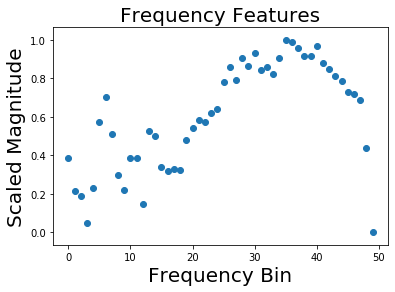

In [484]:
plt.figure(figsize=(6,4))
plt.title("Frequency Features",fontsize=20)
plt.xlabel("Frequency Bin",fontsize=20)
plt.ylabel("Scaled Magnitude",fontsize=20
plt.scatter(y=ff,x=range(len(ff)))
plt.savefig("./plots/ff1.pdf",bbox_inches = "tight")

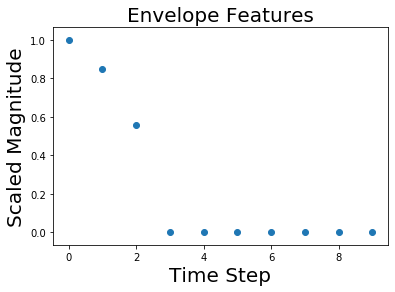

In [485]:
plt.figure(figsize=(6,4))
plt.title("Envelope Features",fontsize=20)
plt.scatter(y=ef,x=range(len(ef)))
plt.ylabel("Scaled Magnitude",fontsize=20)
plt.xlabel("Time Step",fontsize=20)
plt.savefig("./plots/ef1.pdf",bbox_inches = "tight")

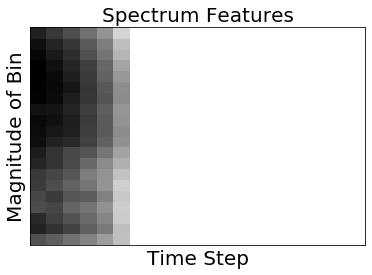

In [486]:
plt.figure(figsize=(6,4))
plt.title("Spectrum Features",fontsize=20)
librosa.display.specshow(sf,cmap='gray_r',)
# sf=sf.detach().numpy()[0]
plt.xlabel("Time Step",fontsize=20)
plt.ylabel("Magnitude of Bin",fontsize=20)
plt.savefig("./plots/sf1.pdf",bbox_inches = "tight")

## FC + env frequency

In [16]:
#define a model for freq categorization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE, D_in,D_out =32,50,2
# H1,H2,H3=100,50,10

# combined_feats=torch.cat((tfList[0](sample)["feats"],tfList[1](sample)["feats"]))

fne=feats_and_env()
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
freq_train = audioDataset(train,".",task="dvn", transform=fne)
freq_test = audioDataset(test,".",task="dvn", transform=fne)
f_train_loader= DataLoader(freq_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=12)
f_test_loader= DataLoader(freq_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)

import imp
imp.reload(pm)  
freq_model=pm.env_freq_Model(D_in=60,H1=30,H2=10,H3=10,device=device)

freq_model.to(device)
pass

In [ ]:
weight=torch.tensor([0.80,0.2]).to(device)
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(freq_model.parameters(), lr=learning_rate)
epochs=20

for i in range(epochs):
    running_loss = 0.0
    
    for j,x in enumerate(f_train_loader):

        f,l=x["feats"].to(device),x["label"].to(device)
  
        optimizer.zero_grad()            
        y_pred = freq_model(f)
        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    correct = 0
    total = 0    
    for j,xt in enumerate(f_test_loader):
        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        outputs = freq_model(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
        acc=(100 * correct / total)
        test_loss=running_loss/train.shape[0]
    if acc>80:
            torch.save(freq_model.state_dict(),'./models/fc/freq_env_dvn_%d_%d.pt'%(acc,running_loss))

    print('Accuracy on test: %d %%' % (acc))
    print(i,running_loss)

## FC ENV

In [29]:
#using env features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_env_feats=1
BATCH_SIZE, D_in,D_out =64,num_env_feats+1,2
H1,H2,H3,H4,H5=10,10,10,5,2

et=tv.transforms.Compose([envTrans(num_env_feats)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
env_train = audioDataset(train,".",task="dvn", transform=et)
env_test = audioDataset(test,".",task="dvn", transform=et)
env_train_loader= DataLoader(env_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)
env_test_loader= DataLoader(env_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
import imp
imp.reload(pm)  

model_env = pm.env_Model(D_in=10,H1=10,H2=5,H3=10,H4=2,H5=10,device=device)
state='./models/fc/env_dvn_96_40.pt'
model_env.load_state_dict(torch.load(state))


weights=torch.tensor([0.1,0.9]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

learning_rate = 0.001
optimizer = torch.optim.Adam(model_env.parameters(), lr=learning_rate)
epochs=30

for i in range(epochs):
    running_loss = 0.0

    for j,x in enumerate(env_train_loader):
        f,l=x["feats"].to(device),x["label"].to(device)
        optimizer.zero_grad()            
        y_pred = model_env(f)
        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    
    correct = 0
    total = 0    
    for j,xt in enumerate(env_test_loader):

        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        outputs = model_env(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
    
    correctness=(100 * correct / total)
    train_loss=running_loss
    save=False
    if correctness>90 or save==True:
            torch.save(model_env.state_dict(),'./models/fc/env_dvn_%d_%d.pt'%(correctness,train_loss))

    print('Accuracy on test: %d %%' % (correctness,))
    print(i,train_loss)   

/home/asalimi/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy on test: 96 %
0 40.00294357538223
Accuracy on test: 95 %
1 39.93404397368431
Accuracy on test: 95 %
2 39.94379618763924
Accuracy on test: 96 %
3 39.90006768703461
Accuracy on test: 95 %
4 39.90484303236008
Accuracy on test: 95 %
5 39.91008147597313
Accuracy on test: 95 %
6 39.85261669754982
Accuracy on test: 95 %
7 39.82824245095253
Accuracy on test: 95 %
8 39.789510905742645
Accuracy on test: 95 %
9 39.844897389411926
Accuracy on test: 95 %
10 39.77098849415779
Accuracy on test: 94 %
11 39.75022366642952
Accuracy on test: 95 %
12 39.702621191740036
Accuracy on test: 95 %
13 39.68821123242378
Accuracy on test: 95 %
14 39.70498874783516
Accuracy on test: 95 %
15 39.72574642300606


KeyboardInterrupt: 

## FC SPEC

In [13]:
#using whole spec features
#define a model for freq categorization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(20)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
pitch_data_train = audioDataset(train,".","dvn", transform=pt)
pitch_data_test = audioDataset(test,".",task="dvn", transform=pt)
pitch_train_loader= DataLoader(pitch_data_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)
pitch_test_loader= DataLoader(pitch_data_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)


import imp
imp.reload(pm)  
pitch_model = pm.getFCSpecModel(D_in=20*20,H1=20,H2=10,H3=4)
pitch_model.to(device)

weights=torch.tensor([0.1,0.9]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

learning_rate = 0.0001
optimizer = torch.optim.Adam(pitch_model.parameters(), lr=learning_rate)
epochs=30

for i in range(epochs):
    running_loss = 0.0

    for j,x in enumerate(pitch_train_loader):
        f,l=x["feats"].to(device),x["label"].to(device)
        f=torch.flatten(f, start_dim=1)
        
        optimizer.zero_grad()            
        y_pred = pitch_model(f)
    
        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    
    correct = 0
    total = 0    
    for j,xt in enumerate(pitch_test_loader):

        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        ft=torch.flatten(ft, start_dim=1)
        outputs = pitch_model(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
    
    correctness=(100 * correct / total)
    train_loss=running_loss/BATCH_SIZE
    save=False
    if correctness>=90 or save==True:
            torch.save(pitch_model.state_dict(),'./models/fc/spec_fc_dvn_%d.pt'%(correctness,))

    print('Accuracy on test: %d ' % (correctness,))
    print(i,train_loss)   

Accuracy on test: 50 
0 1.154164582490921
Accuracy on test: 83 
1 0.9664608440361917
Accuracy on test: 89 
2 0.7932589007541537
Accuracy on test: 91 
3 0.7080285525880754
Accuracy on test: 92 
4 0.6704891249537468
Accuracy on test: 93 
5 0.654713221359998
Accuracy on test: 93 
6 0.645869261585176
Accuracy on test: 93 
7 0.6400371608324349
Accuracy on test: 94 
8 0.6351605327799916
Accuracy on test: 94 
9 0.6325519517995417
Accuracy on test: 94 
10 0.6298092915676534
Accuracy on test: 94 
11 0.627464150544256
Accuracy on test: 95 
12 0.6256300453096628
Accuracy on test: 95 
13 0.6234203861095011
Accuracy on test: 95 
14 0.6218826365657151
Accuracy on test: 95 
15 0.620372417382896
Accuracy on test: 95 
16 0.6203071465715766
Accuracy on test: 95 
17 0.6172990002669394
Accuracy on test: 96 
18 0.6175219542346895
Accuracy on test: 95 
19 0.6164428777992725
Accuracy on test: 95 
20 0.6156319500878453
Accuracy on test: 96 
21 0.6144833229482174
Accuracy on test: 96 
22 0.6146162352524698
Acc

# CNN spec

In [ ]:
#using whole spec features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_pitch_feats=20*21
BATCH_SIZE, D_in,D_out =8,num_pitch_feats+1,2
H1,H2,H3,H4,H5=400,200,100,50,2



pt=tv.transforms.Compose([specTrans(20)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
pitch_data_train = audioDataset(train,".","dvn", transform=pt)
pitch_data_test = audioDataset(test,".",task="dvn", transform=pt)
pitch_train_loader= DataLoader(pitch_data_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)
pitch_test_loader= DataLoader(pitch_data_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)

import pytorch_models as pm
import imp
imp.reload(pm)
mt="cnn"
mt="clst"
if mt=="clst":
    pitch_model = pm.CNNLSTM_dvn()
    state='./models/cnn/clst_dvn_98_306.pt'
    pitch_model.load_state_dict(torch.load(state))
else:
    pitch_model = pm.CNN_dvn()

pitch_model.to(device)
weights=torch.torch.tensor([0.1,0.9]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)


learning_rate = 0.001
optimizer = torch.optim.Adam(pitch_model.parameters(), lr=learning_rate)
epochs=30

for i in range(epochs):
    running_loss = 0.0
    pitch_model.train()
    for j,x in enumerate(pitch_train_loader):
        f,l=x["feats"].to(device),x["label"].to(device)
#         f=torch.flatten(f, start_dim=1)
#         print(f.shape)
#         print(f)
        optimizer.zero_grad()            
        y_pred = pitch_model(f)

        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
#         print(loss.item())
        running_loss+=loss.item()
    
    correct = 0
    total = 0    
    pitch_model.eval()
    for j,xt in enumerate(pitch_test_loader):

        ft,lt=xt["feats"].to(device),xt["label"].to(device)
#         ft=torch.flatten(ft, start_dim=1)
        outputs = pitch_model(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
    
    correctness=(100 * correct / total)
    train_loss=running_loss/BATCH_SIZE
    save=False
    if correctness>=90 or save==True:
            torch.save(pitch_model.state_dict(),'./models/cnn/%s_dvn_%d_%d.pt'%(mt,correctness,running_loss))

    print('loss %d, acc %d' % (running_loss,correctness))